In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#root_path = '/content/gdrive/MyDrive/CorpusData'  #change dir to your project folder 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import string
import re
from pickle import load
from pickle import dump
from unicodedata import normalize
from numpy import array
import pandas as pd
import requests
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax

import matplotlib.pyplot as plt
%matplotlib inline

%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import optimizers

from nltk.translate.bleu_score import corpus_bleu

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, mode='rt', encoding='utf-8')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text
# split a loaded document into sentences
def to_pairs(doc):
	lines = doc.strip().split('\n')
	pairs = [line.split('\t') for line in  lines]
	return pairs
# clean a list of lines
def clean_pairs(lines):
	cleaned = list()
	# prepare regex for char filtering
	re_print = re.compile('[^%s]' % re.escape(string.printable))
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for pair in lines:
		clean_pair = list()
		for line in pair:
			# normalize unicode characters
			line = normalize('NFD', line).encode('ascii', 'ignore')
			line = line.decode('UTF-8')
			# tokenize on white space
			line = line.split()
			# convert to lowercase
			line = [word.lower() for word in line]
			# remove punctuation from each token
			line = [word.translate(table) for word in line]
			# remove non-printable chars from each token
			line = [re_print.sub('', w) for w in line]
			# remove tokens with numbers in them
			line = [word for word in line if word.isalpha()]
			# store as string
			clean_pair.append(' '.join(line))
		cleaned.append(clean_pair)
	return array(cleaned)
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)

# load dataset
filename = '/content/gdrive/MyDrive/eng-fra-40k.txt'
doc = load_doc(filename)

# split into english-oromo pairs
pairs = to_pairs(doc)

# clean sentences
clean_pairs = clean_pairs(pairs)

# save clean pairs to file
save_clean_data(clean_pairs, 'english-french.txt')

# spot check of some texts:
for i in range(20):
	print('%s ...> %s' % (clean_pairs[i,0], clean_pairs[i,1]))


Saved: english-french.txt
go ...> va
go ...> marche
go ...> bouge
hi ...> salut
hi ...> salut
run ...> cours
run ...> courez
run ...> prenez vos jambes a vos cous
run ...> file
run ...> filez
run ...> cours
run ...> fuyez
run ...> fuyons
run ...> cours
run ...> courez
run ...> prenez vos jambes a vos cous
run ...> file
run ...> filez
run ...> cours
run ...> fuyez


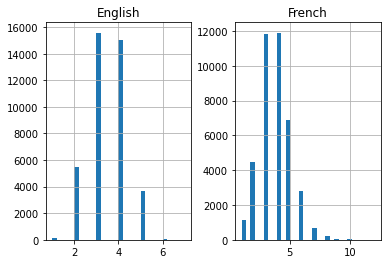

In [ ]:
# empty lists for English and Afaan-Oromo semtences
eng_l = []
fra_l = []

# populate the lists with sentence lengths
for i in clean_pairs [:,0]:
      eng_l.append(len(i.split()))

for i in clean_pairs [:,1]:
     fra_l.append(len(i.split()))

length_df = pd.DataFrame({'English':eng_l, 'French':fra_l})

length_df.hist(bins = 30)
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# save a list of clean sentences to file
def save_clean_data(sentences, filename):
	dump(sentences, open(filename, 'wb'))
	print('Saved: %s' % filename)
 
# load dataset
raw_dataset = load_clean_sentences('english-french.txt')
 
# reduce dataset size to speed up training in demonstration
n_sentences = 35000 
dataset = raw_dataset[:n_sentences, :]

# random shuffle
shuffle(dataset)

# split into train/test
ntest=dataset.shape[0]//5
train, test = dataset[:-ntest], dataset[-ntest:]
print(train.shape,test.shape)

# save
save_clean_data(dataset, 'english-french-both.pkl')
save_clean_data(train, 'english-french-train.pkl')
save_clean_data(test, 'english-french-test.pkl')

(28000, 2) (7000, 2)
Saved: english-french-both.pkl
Saved: english-french-train.pkl
Saved: english-french-test.pkl


In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))
 
# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer
 
# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)
 
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X
 
# one hot encode target sequence
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y
 
# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')
 
# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print('English Vocabulary Size: %d' % eng_vocab_size)
print('English Max Length: %d' % (eng_length))

# prepare french tokenizer
fra_tokenizer = create_tokenizer(dataset[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(dataset[:, 1])
print('French Vocabulary Size: %d' % fra_vocab_size)
print('French Max Length: %d' % (fra_length))
 
# prepare training data
trainX = encode_sequences(fra_tokenizer, fra_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_output(trainY, eng_vocab_size)

# prepare test data
testX = encode_sequences(fra_tokenizer,fra_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_output(testY, eng_vocab_size)

English Vocabulary Size: 4869
English Max Length: 6
French Vocabulary Size: 9914
French Max Length: 12


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 512)           5075968   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 6, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            2099200   
                                                                 
 time_distributed (TimeDistr  (None, 6, 4869)          2497797   
 ibuted)                                                         
                                                                 
Total params: 11,772,165
Trainable params: 11,772,165
No

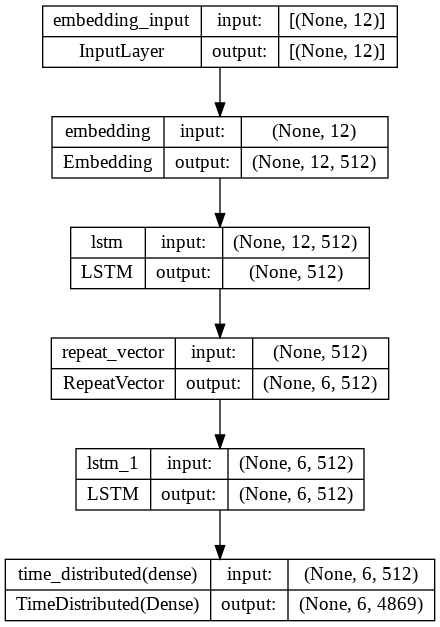

In [ ]:
 #define NMT model
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
	model = Sequential()
	# source word embedding
	model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
	# LSTMs to generate setence encoding
	model.add(LSTM(n_units))
	# repeat source encoding over target sequence
	model.add(RepeatVector(tar_timesteps))
	# LSTMs to generate target sentence
	model.add(LSTM(n_units, return_sequences=True))
	# Dense network to produce distribution over target vocabulary
	model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
	return model

# define model
model = define_model(fra_vocab_size, eng_vocab_size, fra_length, eng_length, 512)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize defined model
print(model.summary())
plot_model(model, to_file='model2.png', show_shapes=True)

In [ ]:
# Fit model
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# set up a checkpoint to save the model each epoch
filename = 'model.h2'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit the model to the training data
history= model.fit(trainX, trainY, epochs=40, batch_size=512, validation_data=(testX, testY), callbacks=[checkpoint], verbose=1)

Epoch 1/40
55/55 [==============================] - ETA: 0s - loss: 4.8144 - accuracy: 0.4496
Epoch 1: val_loss improved from inf to 3.62563, saving model to model.h2
55/55 [==============================] - 32s 394ms/step - loss: 4.8144 - accuracy: 0.4496 - val_loss: 3.6256 - val_accuracy: 0.4745
Epoch 2/40
55/55 [==============================] - ETA: 0s - loss: 3.4487 - accuracy: 0.4791
Epoch 2: val_loss improved from 3.62563 to 3.39895, saving model to model.h2
55/55 [==============================] - 20s 374ms/step - loss: 3.4487 - accuracy: 0.4791 - val_loss: 3.3989 - val_accuracy: 0.4819
Epoch 3/40
55/55 [==============================] - ETA: 0s - loss: 3.3084 - accuracy: 0.4854
Epoch 3: val_loss improved from 3.39895 to 3.31938, saving model to model.h2
55/55 [==============================] - 23s 431ms/step - loss: 3.3084 - accuracy: 0.4854 - val_loss: 3.3194 - val_accuracy: 0.4850
Epoch 4/40
55/55 [==============================] - ETA: 0s - loss: 3.2204 - accuracy: 0.4890
E

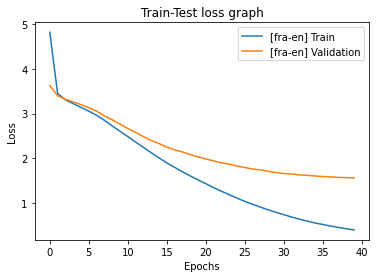

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train-Test loss graph')
plt.legend(['[fra-en] Train','[fra-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

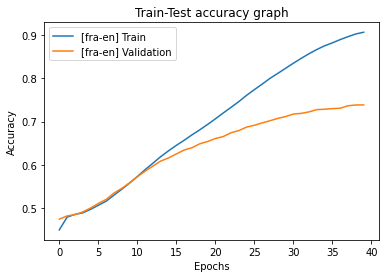

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train-Test accuracy graph')
plt.legend(['[fra-en] Train','[fra-en] Validation'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
# load a clean dataset
def load_clean_sentences(filename):
	return load(open(filename, 'rb'))

# fit a tokenizer
def create_tokenizer(lines):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

# max sentence length
def max_length(lines):
	return max(len(line.split()) for line in lines)

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
	# integer encode sequences
	X = tokenizer.texts_to_sequences(lines)
	# pad sequences with 0 values
	X = pad_sequences(X, maxlen=length, padding='post')
	return X

# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate target given source sequence
def predict_sequence(model, tokenizer, source):
	prediction = model.predict(source, verbose=0)[0]
	integers = [argmax(vector) for vector in prediction]
	target = list()
	for i in integers:
		word = word_for_id(i, tokenizer)
		if word is None:
			break
		target.append(word)
	return ' '.join(target)

# evaluate the performance of the model
def evaluate_model(model, tokenizer, sources, raw_dataset):
  actual, predicted = list(), list()
  for i, source in enumerate(sources):
    # translate encoded source text
    source = source.reshape((1, source.shape[0]))
    translation = predict_sequence(model, eng_tokenizer, source)
    raw_target, raw_src = raw_dataset[i]
    if i < 10:
      print('Source==> [%s], Target==>  [%s], predicted==>  [%s]' % (raw_src, raw_target, translation))
    actual.append([raw_target.split()])
    predicted.append(translation.split())

  # calculate BLEU score
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

# load datasets
dataset = load_clean_sentences('english-french-both.pkl')
train = load_clean_sentences('english-french-train.pkl')
test = load_clean_sentences('english-french-test.pkl')

# prepare english tokenizer
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])

# prepare german tokenizer
fra_tokenizer = create_tokenizer(dataset[:, 1])
fra_vocab_size = len(fra_tokenizer.word_index) + 1
fra_length = max_length(dataset[:, 1])

# prepare data
trainX = encode_sequences(fra_tokenizer,fra_length, train[:, 1])
testX = encode_sequences(fra_tokenizer,fra_length, test[:, 1])

# load model
model = load_model('model.h2')

# test on some training sequences
print('******************** French Train Result:********************')
evaluate_model(model, eng_tokenizer, trainX, train)

# test on some test sequences
print('******************** French Test Result:**********************')
evaluate_model(model, eng_tokenizer, testX, test)

******************** French Train Result:********************
Source==> [jai fait ca aujourdhui], Target==>  [i did that today], predicted==>  [i did it today]
Source==> [en voudraistu], Target==>  [do you want any], predicted==>  [do you want any]
Source==> [je pensais que vous saviez], Target==>  [i thought you knew], predicted==>  [i know you knew]
Source==> [nous sommes separes], Target==>  [were separated], predicted==>  [were separated]
Source==> [on peut le faire tous les deux], Target==>  [we can both do it], predicted==>  [we can all all it]
Source==> [ne parle pas francais], Target==>  [dont speak french], predicted==>  [dont speak french]
Source==> [il est de garde], Target==>  [hes on sentry duty], predicted==>  [hes is sentry]
Source==> [je vais arreter maintenant], Target==>  [ill stop now], predicted==>  [ill stop now]
Source==> [tom aime son emploi], Target==>  [tom loves his work], predicted==>  [tom loves his job]
Source==> [eteins la radio], Target==>  [turn off the 

In [ ]:
print('*********************French Train Result:*********************')
pred_df = pd.DataFrame({'Source': train[:, 1], 'Actual':train[:, 0], 'Predicted':trainX[:, 1] })
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

*********************French Train Result:*********************


,Source,Actual,Predicted
0,jai fait ca aujourdhui,i did that today,31
1,en voudraistu,do you want any,1745
2,je pensais que vous saviez,i thought you knew,2384
3,nous sommes separes,were separated,26
4,on peut le faire tous les deux,we can both do it,124
5,ne parle pas francais,dont speak french,165
6,il est de garde,hes on sentry duty,6
7,je vais arreter maintenant,ill stop now,125
8,tom aime son emploi,tom loves his work,133
9,eteins la radio,turn off the radio,13


In [ ]:
print('********************* French Test Result:*********************')
pred_df = pd.DataFrame({'Source':test[:, 1], 'Actual':test[:, 0], 'Predicted':testX[:,1]})
pd.set_option('display.max_colwidth', 100)
pred_df.head(10)

********************* French Test Result:*********************


,Source,Actual,Predicted
0,jai adore cette voiture,i loved that car,241
1,il se comporte bizarrement,hes behaving oddly,48
2,tom a lair inoffensif,tom seems harmless,3
3,de quoi atil lair,what is he like,162
4,tom demeure mal a laise,tom remains uneasy,1822
5,cest vous linstituteur,youre the teacher,5
6,elles sont trop grosses,theyre too fat,29
7,ok pour heures,i can come at three,74
8,il vous attendra,hell wait for you,5
9,il vit seul,he lives alone,517
